In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

# Read the data

In [3]:
dfXtrain = pd.read_csv('preprocessed_csv/train_more.csv', index_col='id')
dfXtest = pd.read_csv('preprocessed_csv/test_more.csv', index_col='id')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_more.csv', header=None, names=['INDEX', 'P_TARGET_FLAG'])

In [4]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

y_train = np.array(dfYtrain['P_TARGET_FLAG'])

# Save routines

In [5]:
dfYtest = pd.DataFrame({'INDEX': dfXtest.index, 'P_TARGET_FLAG': np.zeros(x_test.shape[0])})
dfYtest.head()

,INDEX,P_TARGET_FLAG
0,3,0.0
1,9,0.0
2,10,0.0
3,18,0.0
4,21,0.0


In [6]:
def save_to_file(y, file_name):
    dfYtest['P_TARGET_FLAG'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False)

# Train RF

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

In [16]:
class RFCcoef():
    def __init__(self, **kwargs):
        self.rfc_kwargs = kwargs
    
    def compute_coef(self, X, y, Xtest, ytest):
        self.features_count = X.shape[1]
        self.coef_ = np.zeros(self.features_count)
        for out_feature in tqdm_notebook(range(self.features_count), desc='out_feature'):
            clf = RFC(**self.rfc_kwargs).fit(np.delete(X, out_feature, 1), y)
            proba = clf.predict_proba(np.delete(Xtest, out_feature, 1))[:, 1]
            self.coef_[out_feature] = roc_auc_score(ytest, proba)
            del clf
            gc.collect()
        return self.coef_

In [10]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [21]:
%%time

kwargs = {'n_estimators': 300, 'class_weight': None, 'max_features': 'auto',
          'criterion': 'entropy', 'n_jobs': -1}

score = np.zeros(x_test.shape[1])
out_feature = np.zeros(x_test.shape[1])

clf = RFCcoef(**kwargs)
X = x_subtrain
Xtest = x_subtest

for features_count in tqdm_notebook(range(x_test.shape[1] - 1, 0, -1), desc='features count'):
    ranking = clf.compute_coef(X, y_subtrain, Xtest, y_subtest)
    out = np.argmax(ranking)
    score[features_count] = ranking[out]
    out_feature[features_count] = out
    X = np.delete(X, out, 1)
    Xtest = np.delete(Xtest, out, 1)
    gc.collect()


CPU times: user 2h 42min 39s, sys: 1min 42s, total: 2h 44min 22s
Wall time: 52min 13s


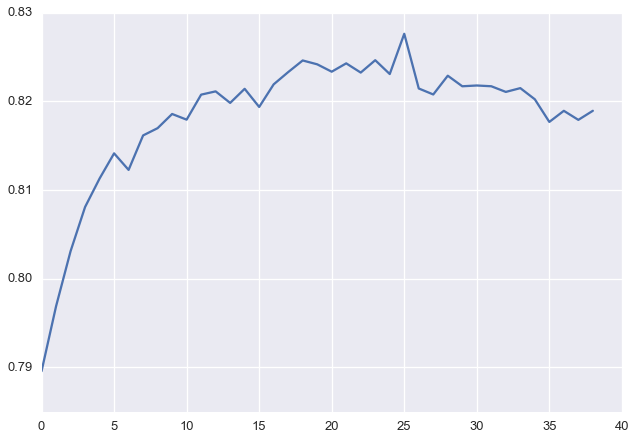

In [22]:
plt.plot(score[10:])

In [24]:
last_out = np.argmax(score)
last_out

35

In [25]:
score[last_out]

0.82762419940551779

In [26]:
out_feature

array([  0.,   0.,   0.,   2.,   0.,   4.,   4.,   6.,   8.,   0.,   6.,
         7.,  12.,   6.,   1.,  13.,  15.,   7.,   8.,  16.,  15.,  19.,
         2.,  18.,  12.,  17.,  14.,  10.,   1.,  24.,  18.,  25.,  22.,
        15.,  34.,   9.,  30.,  13.,  32.,   5.,  34.,  17.,  19.,  34.,
        35.,   7.,  33.,  14.,  46.])

In [29]:
out_feature.shape[0] - last_out

14

In [44]:
%%time

X = x_subtrain
Xtest = x_subtest
columns = np.array(dfXtest.columns.tolist())

for features_count in tqdm_notebook(range(x_test.shape[1] - 1, last_out - 1, -1), desc='features count'):
    out = out_feature[features_count]
    X = np.delete(X, out, 1)
    Xtest = np.delete(Xtest, out, 1)
    columns = np.delete(columns, out)


CPU times: user 63.5 ms, sys: 0 ns, total: 63.5 ms
Wall time: 61.2 ms


In [47]:
set(dfXtest.columns.tolist()) - set(columns)

{'age_nan',
 'car_age',
 'car_type_Sports Car',
 'clm_freq',
 'education_<High School',
 'education_Bachelors',
 'education_Masters',
 'education_PhD',
 'income_ano',
 'income_nan',
 'job_Other',
 'job_z_Blue Collar',
 'yoj',
 'yoj_ano'}

In [48]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict_proba(X)[:, 1]
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, rf_prediction))
    return score

In [51]:
%%time

kwargs = {'n_estimators': 1000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

clf = RFC(**kwargs)
clf.fit(X, y_subtrain)
test_score = get_score_list(Xtest, y_subtest, clf, roc_auc_score)

CPU times: user 25.8 s, sys: 233 ms, total: 26.1 s
Wall time: 10.6 s


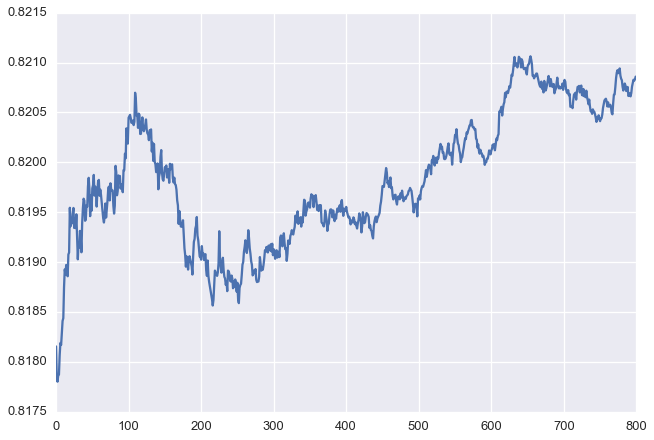

In [52]:
plt.plot(test_score[200:])

In [53]:
%%time

X = x_train
Xtest = x_test

for features_count in tqdm_notebook(range(x_test.shape[1] - 1, last_out - 1, -1), desc='features count'):
    out = out_feature[features_count]
    X = np.delete(X, out, 1)
    Xtest = np.delete(Xtest, out, 1)



CPU times: user 90.4 ms, sys: 4.03 ms, total: 94.4 ms
Wall time: 91.9 ms


In [55]:
%%time

kwargs = {'n_estimators': 3000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 42}

clf = RFC(**kwargs)
clf.fit(X, y_train)

proba = clf.predict_proba(Xtest)[:, 1]
save_to_file(proba, 'more_3000_35_best.csv')

CPU times: user 1min 24s, sys: 998 ms, total: 1min 25s
Wall time: 28.4 s


In [58]:
%%time

kwargs = {'n_estimators': 5000, 'criterion': 'entropy', 'n_jobs': -1}

proba = np.zeros(Xtest.shape[0])

for random_state in tqdm_notebook(range(1, 21), desc='random_state'):
    rfc = RFC(random_state=random_state, **kwargs)
    rfc.fit(X, y_train)
    proba += rfc.predict_proba(Xtest)[:, 1]
    del rfc
    gc.collect()


CPU times: user 49min 7s, sys: 24.6 s, total: 49min 32s
Wall time: 23min 5s


In [59]:
proba /= 20

In [60]:
save_to_file(proba, 'more_35_best_100_000_cycle.csv')

In [61]:
gc.collect()

9